In [1]:
import sys 
sys.path.append('../scripts/')
from dynamic_programming import *

In [2]:
class BeliefDynamicProgramming(DynamicProgramming):
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, camera, puddle_coef=100.0, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): 
        super().__init__(widths, goal, puddles, time_interval, sampling_num, puddle_coef, lowerleft, upperright)  ###amdp6changeactions（4-9行目）
        
        self.actions = [(0.0, 2.0), (0.0, -2.0), (1.0, 0.0), (-0.9, 0.0)] #バック（-1.0, 0.0）を追加してself.actionsを再定義（この位置に！）
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num) #追加。計算し直し。
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1])
        nx, ny, nt, nh = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))
        
        self.value_function, self.final_state_flags =  self.init_belief_value_function()
        self.policy = np.zeros(np.r_[self.index_nums,2]) 
        
        self.dev_borders = dev_borders
        self.dev_borders_side = [dev_borders[0]/10, *dev_borders, dev_borders[-1]*10]
        self.motion_sigma_transition_probs = self.init_motion_sigma_transition_probs()
        self.obs_sigma_transition_probs = self.init_obs_sigma_transition_probs(camera) #追加

    def init_obs_sigma_transition_probs(self, camera):
        probs = {}
        for index in self.indexes: 
            pose = self.pose_min + self.widths*(np.array(index[0:3]).T + 0.5)   
            sigma = (self.dev_borders_side[index[3]] + self.dev_borders_side[index[3]+1])/2
            S = (sigma**2)*np.eye(3)

            for d in camera.data(pose):
                S = self.observation_update(d[1], S, camera, pose)
                    
            probs[index] = {self.cov_to_index(S):1.0}

        return probs
    
    def observation_update(self, landmark_id, S, camera, pose):
        distance_dev_rate = 0.14
        direction_dev = 0.05
        
        H = matH(pose, camera.map.landmarks[landmark_id].pos)
        estimated_z = IdealCamera.observation_function(pose, camera.map.landmarks[landmark_id].pos)
        Q = matQ(distance_dev_rate*estimated_z[0], direction_dev)
        K = S.dot(H.T).dot(np.linalg.inv(Q + H.dot(S).dot(H.T)))
        return (np.eye(3) - K.dot(H)).dot(S)
        
    def init_motion_sigma_transition_probs(self):
        probs = {}
        for a in self.actions:
            for i in range(len(self.dev_borders)+1):
                probs[(i, a)] = self.calc_motion_sigma_transition_probs(self.dev_borders_side[i], self.dev_borders_side[i+1], a)
                
        return probs
            
    def cov_to_index(self, cov):
        sigma = np.power(np.linalg.det(cov), 1.0/6)
        for i, e in enumerate(self.dev_borders):
            if sigma < e: return i
            
        return len(self.dev_borders)
        
    def calc_motion_sigma_transition_probs(self, min_sigma, max_sigma, action, sampling_num=100):
        nu, omega = action
        if abs(omega) < 1e-5: omega = 1e-5

        F = matF(nu, omega, self.time_interval, 0.0) #ロボットの向きは関係ないので0[deg]で固定で
        M = matM(nu, omega, self.time_interval, {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2})#移動の誤差モデル（カルマンフィルタのものをコピペ）
        A = matA(nu, omega, self.time_interval, 0.0)
        
        ans = {}
        for sigma in np.linspace(min_sigma, max_sigma*0.999, sampling_num): #遷移前のσを作る（区間内に一様分布していると仮定）
            index_after = self.cov_to_index(sigma*sigma*F.dot(F.T) + A.dot(M).dot(A.T)) #遷移後のσのインデックス
            ans[index_after] = 1 if index_after not in ans else ans[index_after] + 1 #単にカウントしてるだけ（辞書の初期化もあるのでややこしい）
                
        for e in ans:
            ans[e] /= sampling_num #頻度を確率に

        return ans
    
    def init_belief_value_function(self): 
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.belief_final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def belief_final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index[0:3] 
        x_max, y_max, _ = self.pose_min + self.widths*(index[0:3] + 1) 
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] 
        return all([self.goal.inside(np.array(c).T) for c in corners ]) and index[3] == 0
    
    def action_value(self, action, index, out_penalty=True):###amdp6
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:
            after, out_reward = self.out_correction(np.array(index[0:3]).T + delta)
        
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            for sigma_after, sigma_prob in self.motion_sigma_transition_probs[(index[3], action)].items():
                for sigma_obs, sigma_obs_prob in dp.obs_sigma_transition_probs[(*after, sigma_after)].items(): #もう一段追加
                    value += (self.value_function[(*after, sigma_obs)] + reward) * prob * sigma_prob * sigma_obs_prob #確率の掛け算も追加

        return value

In [3]:
puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]

##地図とカメラを作る##
m = Map()
for ln in [(1,4), (4,1), (-4, 1), (-2, 1)]: m.append_landmark(Landmark(*ln))
c = IdealCamera(m)
    
dp = BeliefDynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10, c) #カメラを加える

In [4]:
def save():
    with open("policy_amdp.txt", "w") as f:  ###amdp6sweeps
        for index in dp.indexes:
            p = dp.policy[index]
            f.write("{} {} {} {} {} {}\n".format(index[0], index[1], index[2],index[3], p[0], p[1])) #一つ{}とindexの要素を増やす

    with open("value_amdp.txt", "w") as f:
        for index in dp.indexes:
            p = dp.value_function[index]
            f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], index[3], p)) #5行目と同じ

delta = 1e100
counter = 0

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)
    save()

1 99.89247285515103
2 98.16110534922072
3 53.09260010520238
4 41.44764812439141
5 28.87260673648374
6 20.679323313728965
7 18.550223347427313
8 16.602059074362877
9 15.170424803880536
10 14.106154990051436
11 13.295145712229335
12 12.358113015499384
13 11.47406779961964
14 10.304766569372575
15 9.09815737170301
16 8.637314936369265
17 8.237183761707598
18 7.908393895159463
19 7.607545247852045
20 7.3347812901159415
21 7.087251181356933
22 6.862016906938031
23 6.657614047625522
24 6.474718379358002
25 6.3045745419472325
26 6.146550691563647
27 5.9988867812609215
28 5.8613931123326
29 5.735539188374432
30 5.617796429621002
31 5.507200846296932
32 5.40292431509306
33 5.304274736546972
34 5.210683816346183
35 5.121687252736983
36 5.036893072715159
37 4.955924470573457
38 4.878388793227543
39 4.7884149285241335
40 4.628023042562006
41 4.407614935991823
42 4.215216555635919
43 3.9994919769534647
44 3.776379190635467
45 3.6610354018118088
46 3.489412370670429
47 3.3165452076129966
48 3.144909

<IPython.core.display.Javascript object>


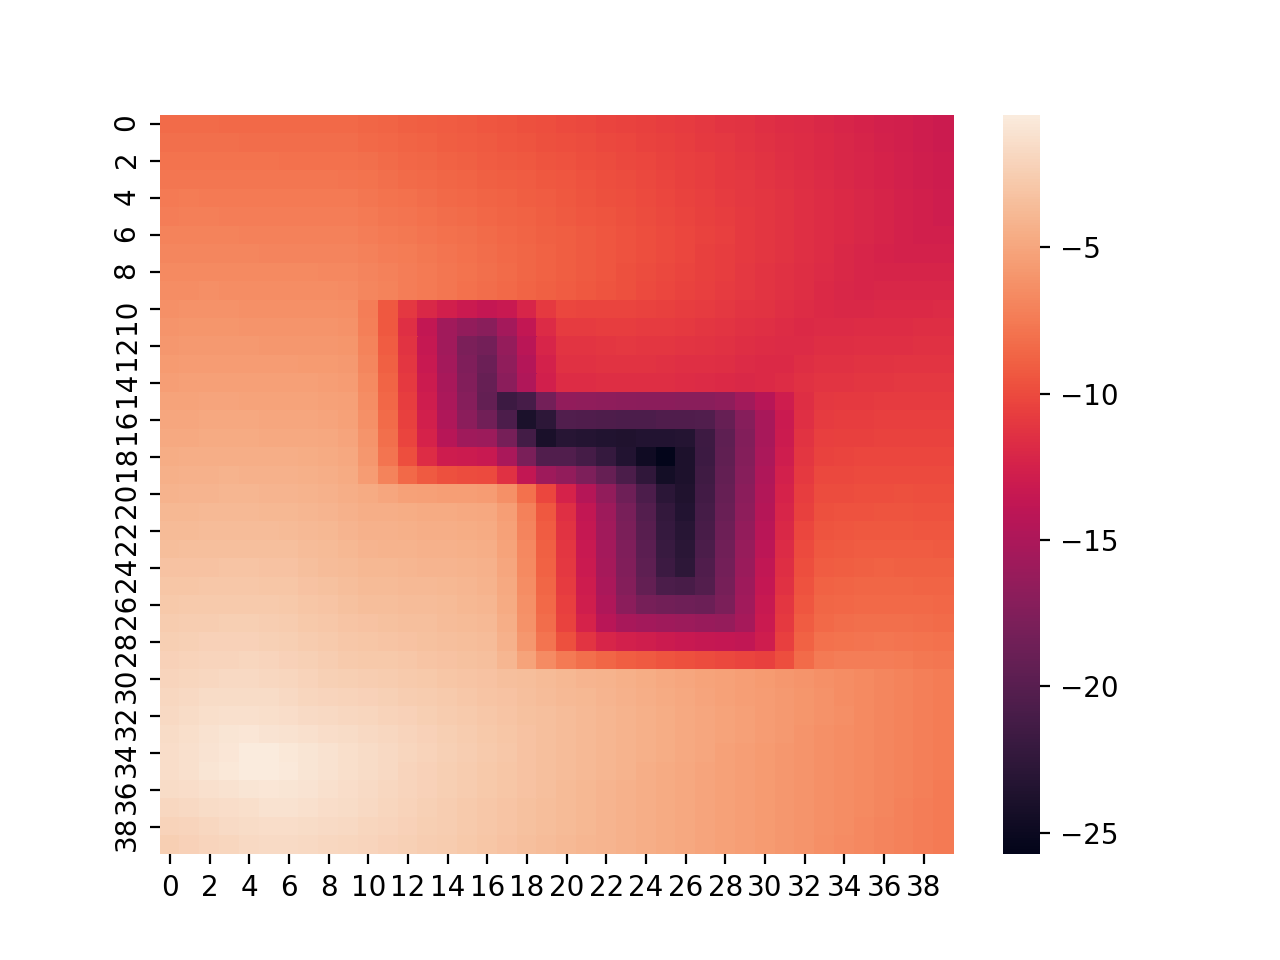

In [5]:
import seaborn as sns
v = dp.value_function[:, :, 18, 4]
sns.heatmap(np.rot90(v), square=False)
plt.show()